## Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from google.colab import drive

import librosa
import librosa.display as dsp
import IPython.display as ipd

warnings.filterwarnings(action='ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(813)

train = pd.read_csv('/content/drive/MyDrive/drive-download-20220614T024615Z-001/train.csv')
test = pd.read_csv('/content/drive/MyDrive/drive-download-20220614T024615Z-001/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/drive-download-20220614T024615Z-001/sample_submission.csv')

## EDA

**실제 각 라벨별 음성 데이터를 시각화하여 특징 찾기**

In [7]:
#train의 라벨 상태
train.label.groupby(train.label).count()

label
0    40
1    40
2    40
3    40
4    40
5    40
6    40
7    40
8    40
9    40
Name: label, dtype: int64

In [8]:
### 오디오 시각화

def get_audio(num = 0):
    #Audio Sample Directory
    sample =  os.listdir('/content/drive/MyDrive/Dacon/train')
    temp = train[train.label == num].file_name #0~9까지 출력
    file_name =  temp[temp.index[0]]

    file = '/content/drive/MyDrive/Dacon/train/' + file_name
    #Get Audio from the location
    data, sample_rate = librosa.load(file)

    #Plot the audio wave
    dsp.waveshow(data, sr=sample_rate)
    plt.show()




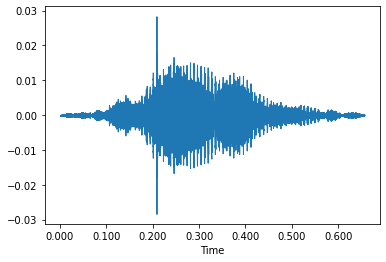

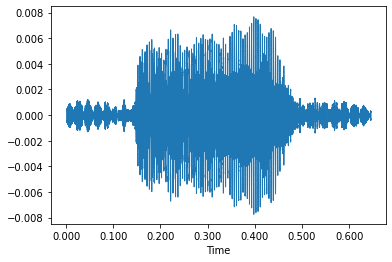

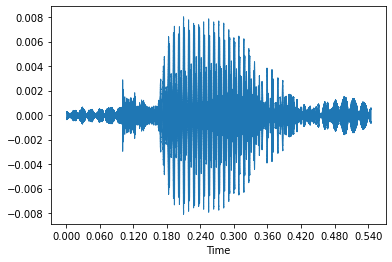

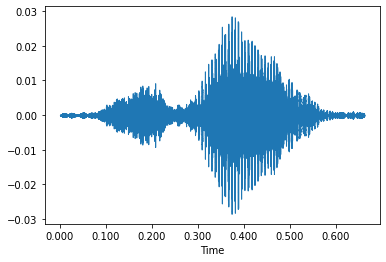

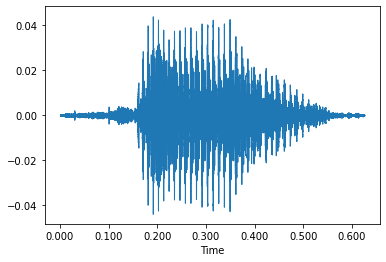

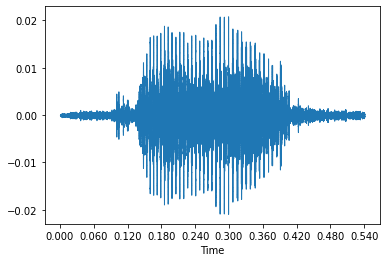

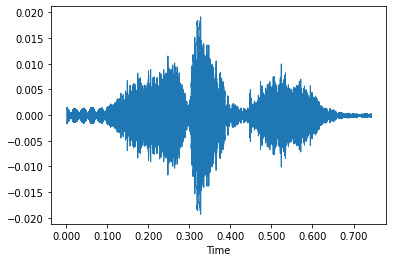

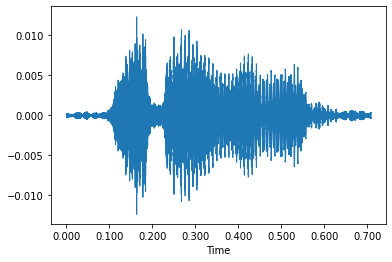

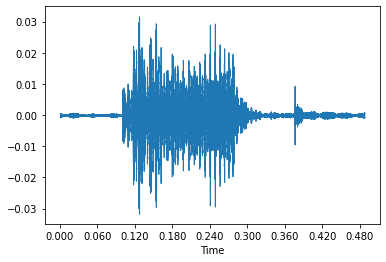

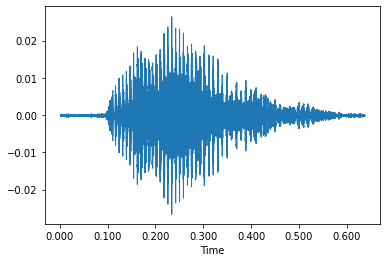

In [9]:
#label 0~9까지 그림
for j in range(0,10):
    get_audio(j)


**주파수 성분을 뽑기 위한 퓨리에 변환**

In [10]:
#FFT를 통해 원본 소리 데이터를 형성하는 주파ㅅ의 정도 파악 후 시각화

def fourier_transform(num=0):
    #Audio Sample Directory
    sample = os.listdir('/content/drive/MyDrive/Dacon/train')
    temp = train[train.label ==num].file_name
    file_name = temp[temp.index[0]]

    file = '/content/drive/MyDrive/Dacon/train/' + file_name
    #Get Audio from the location
    data, sample_rate = librosa.load(file)

    fft = np.fft.fft(data)

    magnitude = np.abs(fft)
    frequency =  np.linspace(0, sample_rate, len(magnitude))

    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(magnitude)/2)]

    fig = plt.figure(figsize = (14,5))
    plt.plot(left_frequency, left_magnitude)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title(f"Fourier transform of audio label {num}")
    plt.show()

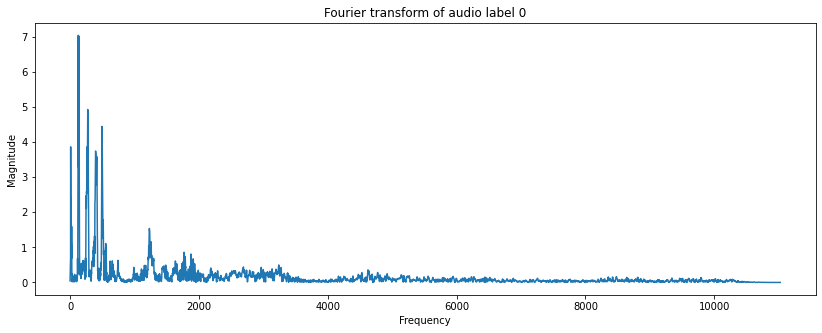

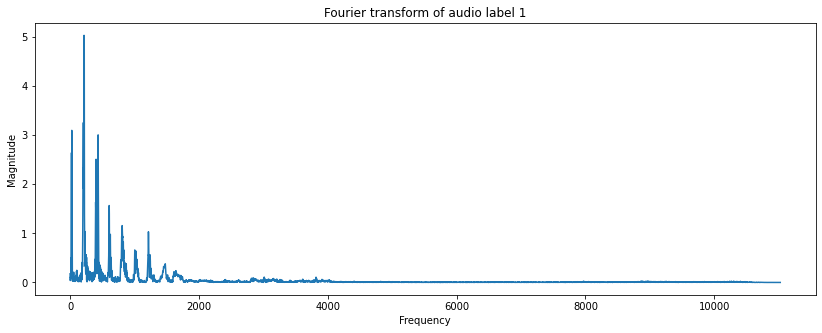

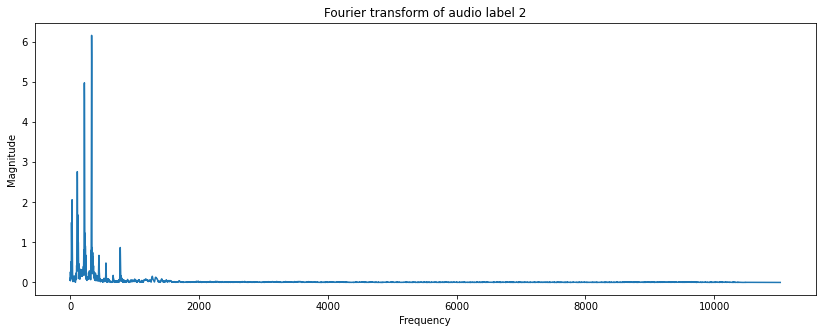

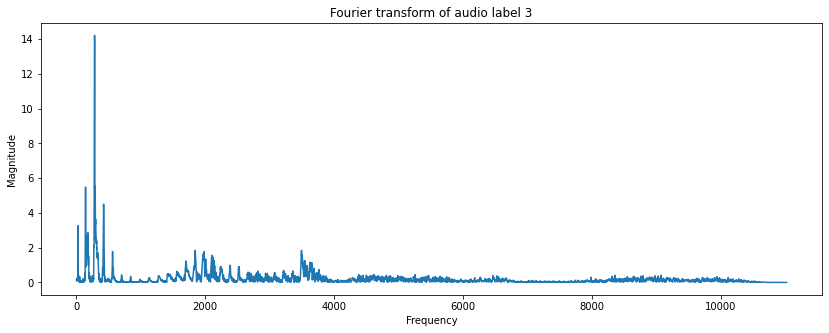

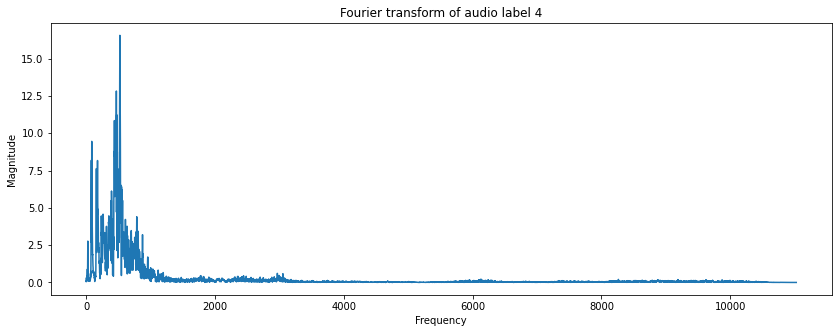

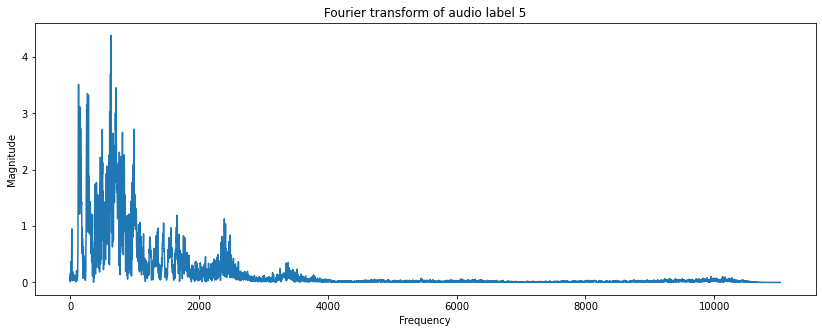

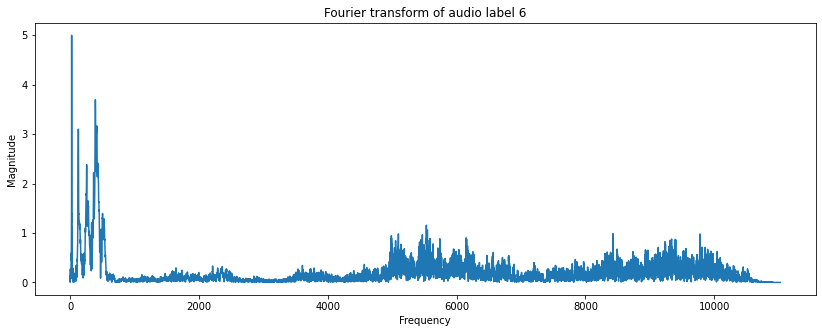

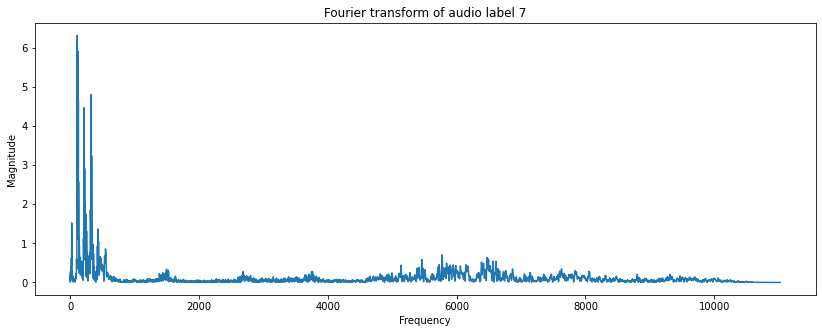

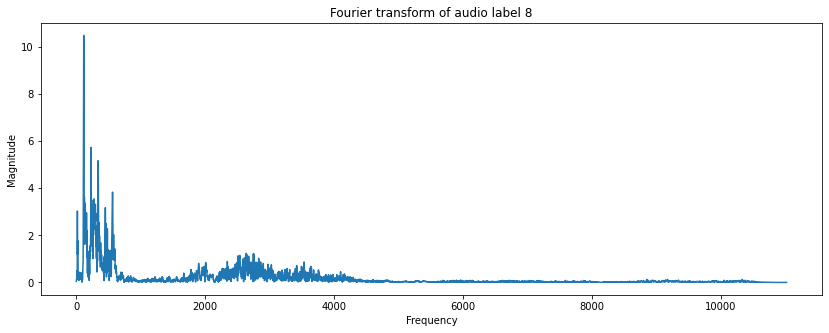

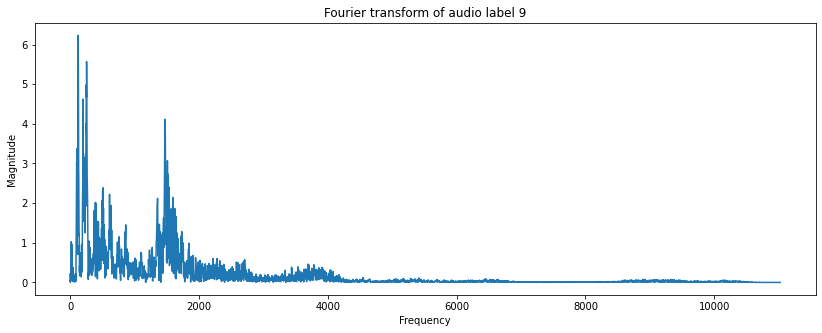

In [11]:
for i in range(0,10):
    fourier_transform(i)

**Mel Spectrogram**


- 주파수를 mel-scale로 변환한 형태

   - 높은 주파수일수록 민감하게 받아들인다.



### Argument


**n_fft : 한 번 fft를 해 줄 만큼의 sequence 길이**

여기서 n_fft는 window size라고도 부르는데, frame의 length를 결정하는 파라미터 입니다.

사람의 목소리는 대부분 16000Hz 안에 포함이 되는데,

일반적으로 자연어 처리에서는 음성을 25m의 크기를 기본으로 하고 있습니다.

따라서 16000Hz인 음성에서는 25m의 음성의 크기를 가지고 있으면 n_fft는 16000 * 0.025 = 400 (sampling rate * frame_length = n_fft)가 됩니다.

<br>

**hop_length : window 간의 거리**

hop_length도 마찬가지로 window 간의 거리이므로 sampling rate * frame_stride 가 됩니다.

<br>

**win_length : 윈도우 길이**

보통 win_length를 지정하지 않으면 n_fft가 됩니다.



In [16]:
def Mel_s(num = 0, frame_length = 0.025, frame_stride = 0.010):

    sample = os.listdir('/content/drive/MyDrive/Dacon/train')
    temp = train[train.label == num].file_name
    file_name = temp[temp.index[0]]
    
    file = '/content/drive/MyDrive/Dacon/train/' + file_name
    data,sample_rate = librosa.load(file, sr = 22050)
    #sr의 default는 22050
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    
    S = librosa.feature.melspectrogram(y=data, n_mels=100, n_fft=input_nfft, hop_length=input_stride)
    
    print("Wav length: {}, Mel_S shape:{}".format(len(data)/sample_rate, np.shape(S)))
    
    S_dB  = librosa.power_to_db(S, ref=np.max)
    fig = plt.figure(figsize = (14,5))
    librosa.display.specshow(S_dB, 
                             sr=sample_rate, 
                             hop_length=input_stride,
                             x_axis='time',
                             y_axis='log')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel spectrogram of audio label {num}")
    plt.show()

Wav length: 0.6563265306122449, Mel_S shape:(100, 66)


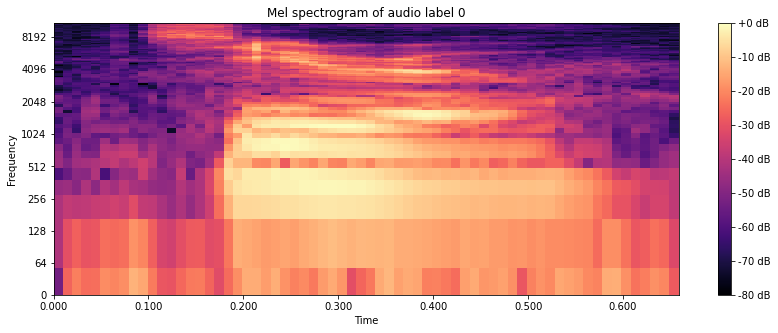

Wav length: 0.6454875283446712, Mel_S shape:(100, 65)


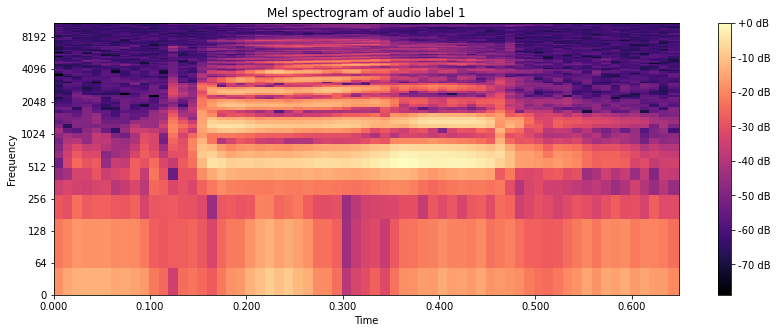

Wav length: 0.5443990929705216, Mel_S shape:(100, 55)


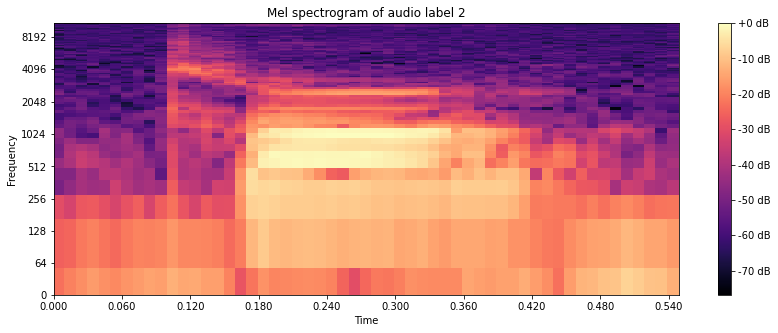

Wav length: 0.6616326530612245, Mel_S shape:(100, 67)


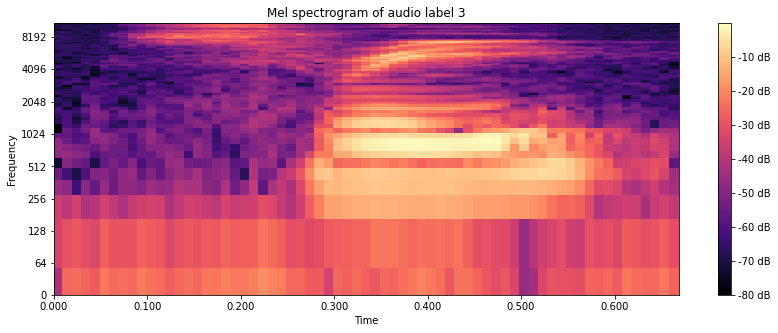

Wav length: 0.625578231292517, Mel_S shape:(100, 63)


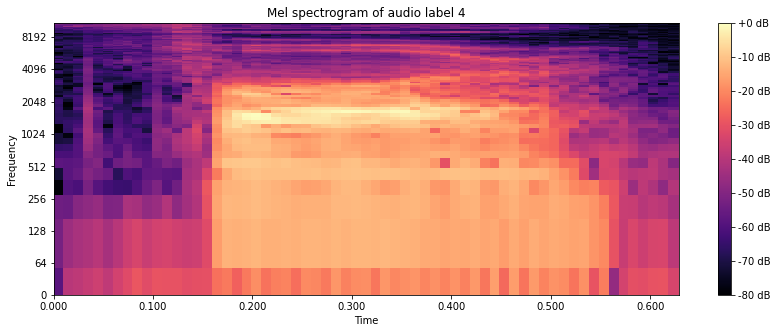

Wav length: 0.5401360544217687, Mel_S shape:(100, 55)


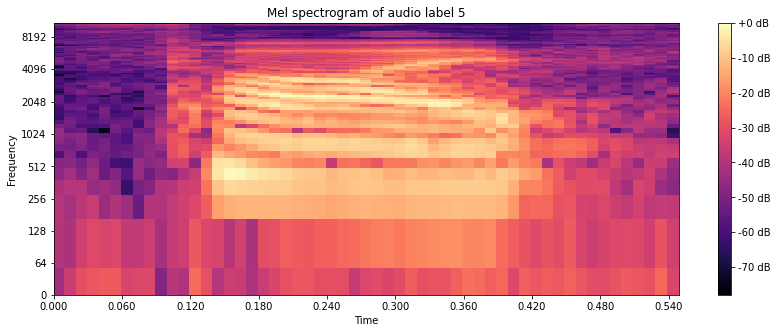

Wav length: 0.7418140589569161, Mel_S shape:(100, 75)


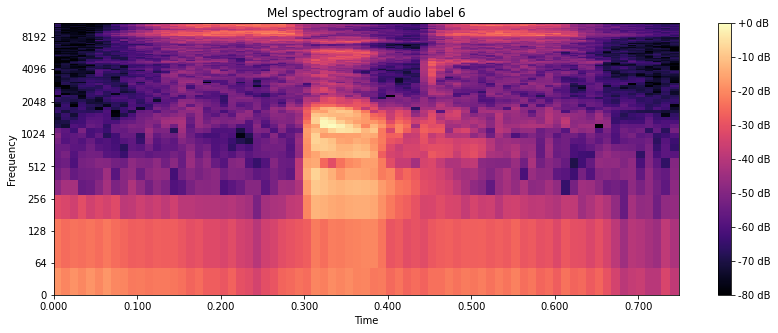

Wav length: 0.707891156462585, Mel_S shape:(100, 71)


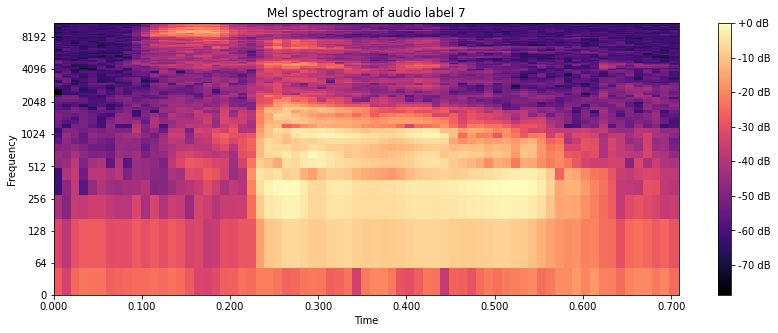

Wav length: 0.48766439909297055, Mel_S shape:(100, 49)


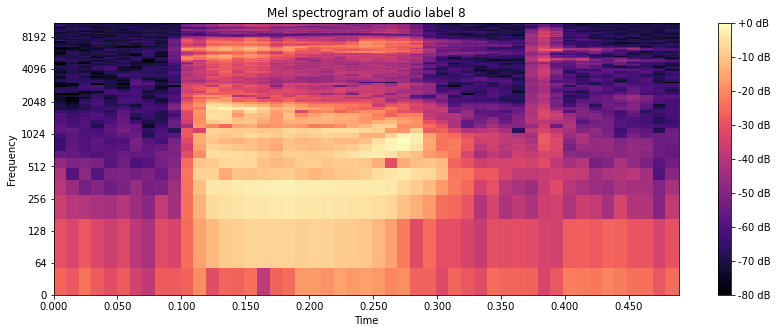

Wav length: 0.6370068027210884, Mel_S shape:(100, 64)


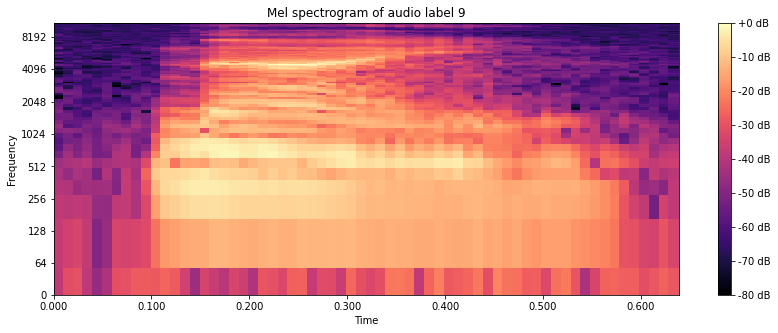

In [17]:
for i in range(0,10):
    Mel_s(i)